## Data Processing

In [2]:
import os
import shutil
import random
from pathlib import Path
from tqdm import tqdm

# Paths
SOURCE_DIR = Path("/kaggle/input/fresh-and-stale-classification/dataset/Train")
DEST_DIR = Path("/kaggle/working/split_dataset")
TRAIN_DIR = DEST_DIR / "Train"
VAL_DIR = DEST_DIR / "Val"
TEST_DIR = DEST_DIR / "Test"

# Reproducibility
SEED = 42
random.seed(SEED)

# Remove old split directory if exists
if DEST_DIR.exists():
    shutil.rmtree(DEST_DIR)

# Create destination directories
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    split_dir.mkdir(parents=True, exist_ok=True)

# Split logic
SPLIT_RATIOS = {"train": 0.7, "val": 0.15, "test": 0.15}

# Loop through each class
for class_dir in tqdm(list(SOURCE_DIR.iterdir()), desc="Splitting data"):
    if not class_dir.is_dir():
        continue
    images = list(class_dir.glob("*"))
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * SPLIT_RATIOS["train"])
    n_val = int(n_total * SPLIT_RATIOS["val"])
    n_test = n_total - n_train - n_val

    splits = {
        TRAIN_DIR / class_dir.name: images[:n_train],
        VAL_DIR / class_dir.name: images[n_train:n_train + n_val],
        TEST_DIR / class_dir.name: images[n_train + n_val:]
    }

    for dest_class_dir, files in splits.items():
        dest_class_dir.mkdir(parents=True, exist_ok=True)
        for file in files:
            shutil.copy(file, dest_class_dir)

Splitting data: 100%|██████████| 18/18 [02:34<00:00,  8.57s/it]


In [3]:
import os
import shutil
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === Config ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 42

# === Paths ===
BASE_DIR = Path("/kaggle/working/split_dataset")  # Update accordingly
TRAIN_DIR = BASE_DIR / "Train"
VAL_DIR = BASE_DIR / "Val"
TEST_DIR = BASE_DIR / "Test"

# === Reproducibility ===
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# === Load datasets (NO validation_split here) ===
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# === Class Names ===
class_names = raw_train_ds.class_names
print(f"Number of classes: {len(class_names)}")
print("Class names:", class_names)

# === Normalize and prefetch ===
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(tf.data.AUTOTUNE)
val_ds   = raw_val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(tf.data.AUTOTUNE)
test_ds  = raw_test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

2025-08-05 02:58:09.049330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754362689.226318      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754362689.273318      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 16524 files belonging to 18 classes.


I0000 00:00:1754362701.943104      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 3535 files belonging to 18 classes.
Found 3560 files belonging to 18 classes.
Number of classes: 18
Class names: ['freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottenbittergroud', 'rottencapsicum', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']


## Phase 1: Build & Train Custom CNN (Baseline)

In [4]:
# === Build CNN ===
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=18):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# === Compile ===
basic_model = build_custom_cnn()
basic_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

basic_model.summary()

# === Early stopping ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,  # wait for 3 epochs before stopping
    restore_best_weights=True,
    verbose=1
)

checkpoint_basic = ModelCheckpoint(
    filepath="best_basic_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,978 (441.32 KB)

 Trainable params: 112,530 (439.57 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Train
basic_model_history = basic_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Set slightly high; EarlyStopping will stop early
    callbacks=[early_stop, checkpoint_basic]
)

Epoch 1/20


I0000 00:00:1754360203.201754     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5230 - loss: 1.5927
Epoch 1: val_loss improved from inf to 5.14271, saving model to best_basic_model.keras
259/259 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.5234 - loss: 1.5910 - val_accuracy: 0.0798 - val_loss: 5.1427
Epoch 2/20
258/259 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7738 - loss: 0.6853
Epoch 2: val_loss improved from 5.14271 to 2.61714, saving model to best_basic_model.keras
259/259 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.7739 - loss: 0.6849 - val_accuracy: 0.2498 - val_loss: 2.6171
Epoch 3/20
258/259 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8217 - loss: 0.5134
Epoch 3: val_loss improved from 2.61714 to 0.82716, saving model to best_basic_model.keras
259/259 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.8218 - loss: 0.5131 - val_accuracy: 0.7231 - val_loss: 0.8272
Epoch 4/20
258/259 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8480 - loss: 0.4131
Epoch 4: val_loss improved from 0.8

In [12]:
# 1. Reload the best fine-tuned weights
basic_model.load_weights("best_basic_model.keras")

# 2. Evaluate on the test dataset (already normalized)
test_loss, test_acc = basic_model.evaluate(test_ds, verbose=1)

# 3. Print results
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9010 - loss: 0.2770

Test Accuracy: 88.90%
Test Loss: 0.2987


In [11]:
from sklearn.metrics import classification_report
import numpy as np

# 1. Get ground truth and predictions
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = basic_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Classification report
print(classification_report(y_true, y_pred, target_names=raw_test_ds.class_names))

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step
                   precision    recall  f1-score   support

      freshapples       1.00      0.81      0.89       365
      freshbanana       0.96      1.00      0.98       371
 freshbittergroud       1.00      0.84      0.91        50
    freshcapsicum       1.00      1.00      1.00       149
    freshcucumber       0.67      0.49      0.57        75
        freshokra       0.58      0.91      0.70        96
     freshoranges       0.91      0.94      0.92       221
      freshpotato       0.48      0.99      0.65        81
      freshtomato       0.89      0.99      0.94       280
     rottenapples       0.81      0.98      0.89       488
     rottenbanana       0.98      1.00      0.99       441
rottenbittergroud       0.98      1.00      0.99        55
   rottencapsicum       1.00      1.00      1.00       136
   rottencucumber       0.71      0.42      0.53        64
       rottenokra       0.60      0.23      0.33        52
    rottenorang

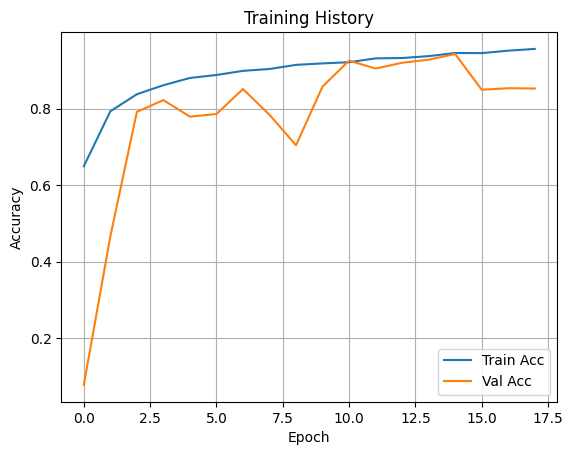

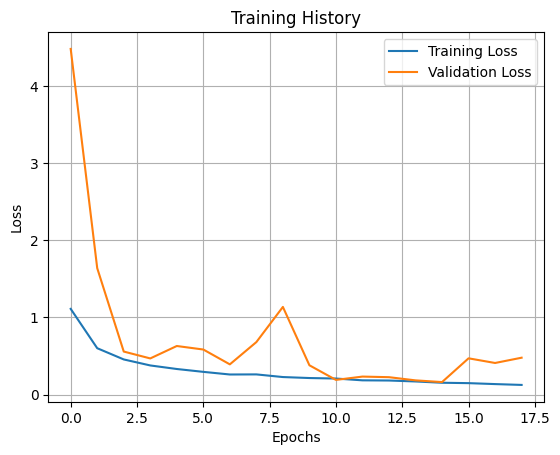

In [6]:
import matplotlib.pyplot as plt

plt.plot(basic_model_history.history['accuracy'], label='Train Acc')
plt.plot(basic_model_history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training History')
plt.show()
    
plt.plot( basic_model_history.history["loss"], label = "Training Loss")
plt.plot( basic_model_history.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title('Training History')
plt.show()

### Visualize Sample Predictions (Correct & Incorrect)

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step


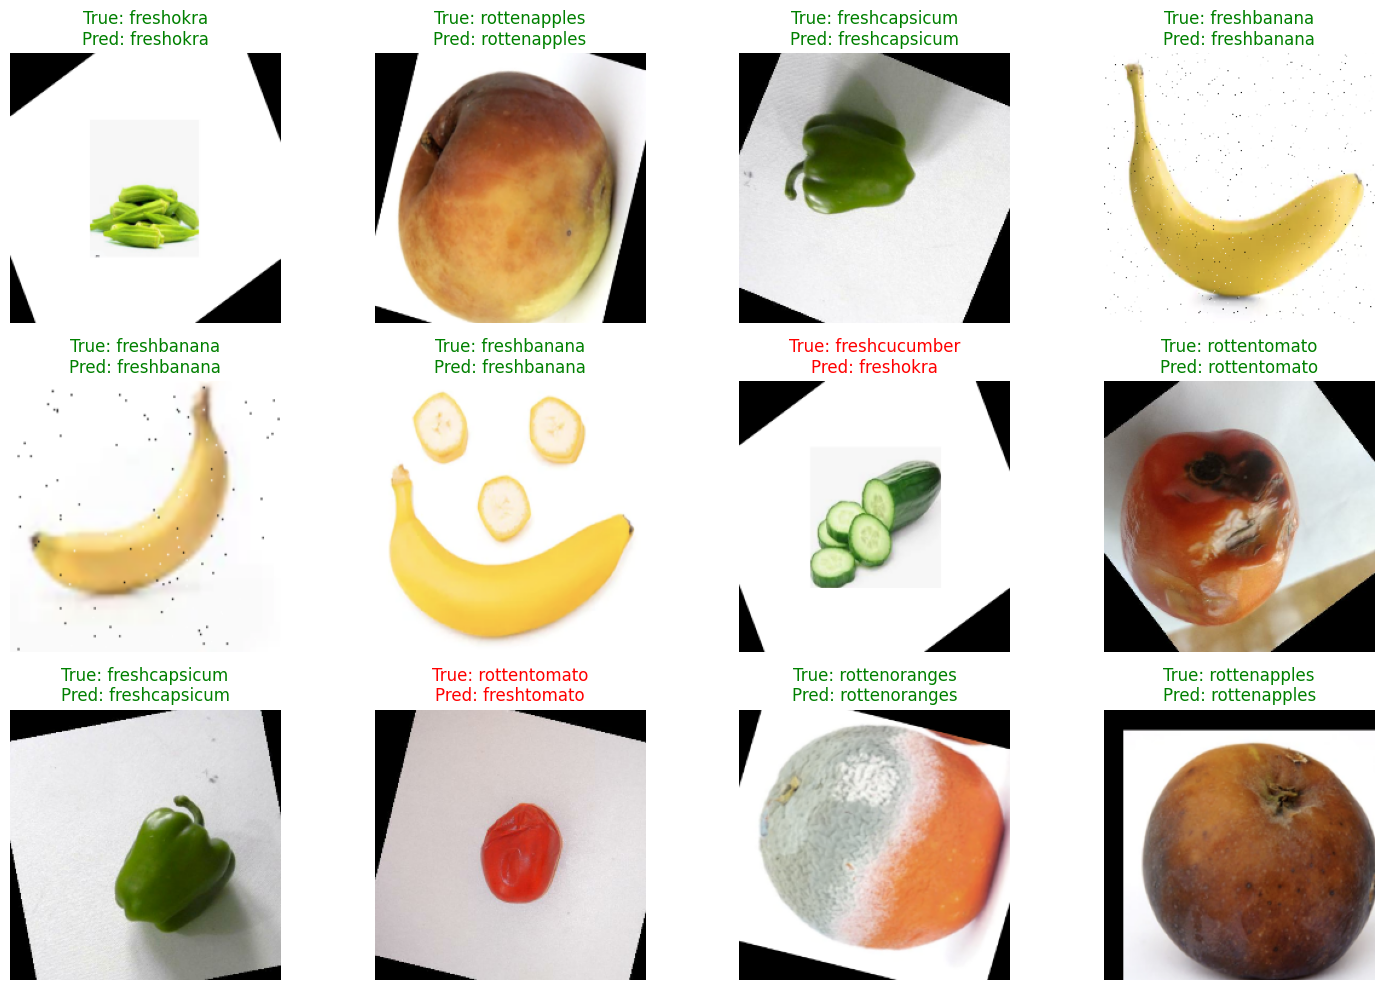

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get test images and labels
class_names = raw_test_ds.class_names
test_images = np.concatenate([x.numpy() for x, y in test_ds])
test_labels = np.concatenate([y.numpy() for x, y in test_ds])

# Predict labels
y_pred_probs = basic_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Fix: Rescale normalized images to [0, 255] for display
def denormalize(image):
    image = image * 255.0
    return np.clip(image, 0, 255).astype("uint8")

# Plot sample predictions
def plot_sample_predictions(images, y_true, y_pred, class_names, num_samples=12):
    plt.figure(figsize=(15, 10))
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        ax = plt.subplot(3, 4, i + 1)
        image = denormalize(images[idx])
        plt.imshow(image)
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        color = "green" if y_true[idx] == y_pred[idx] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_sample_predictions(test_images, test_labels, y_pred, class_names)


### Plot Accuracy and Loss Curves

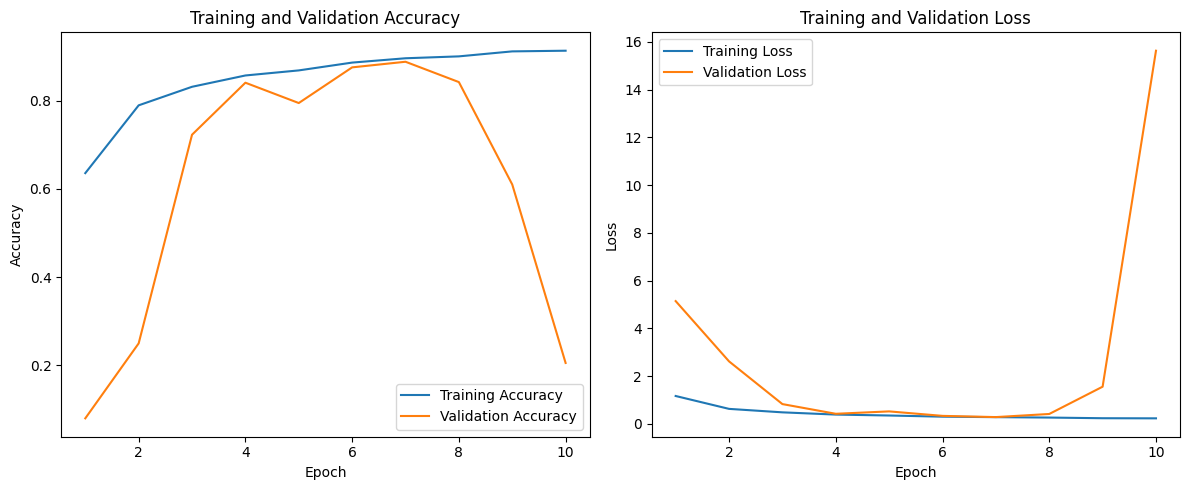

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(basic_model_history)


## Phase 2: Fine Tune Basic Model

In [5]:
import tensorflow as tf
from pathlib import Path

# === Config ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 42

# === Paths ===
BASE_DIR = Path("/kaggle/working/split_dataset")  # Update accordingly
TRAIN_DIR = BASE_DIR / "Train"
VAL_DIR = BASE_DIR / "Val"
TEST_DIR = BASE_DIR / "Test"

# === Reproducibility ===
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# === Load datasets (NO validation_split here) ===
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# === Class Names ===
class_names = raw_train_ds.class_names
print(f"Number of classes: {len(class_names)}")
print("Class names:", class_names)

# === Data Augmentation Layer (less aggressive) ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),  # reduced from 0.05
    tf.keras.layers.RandomZoom(0.05),      # reduced from 0.05
    tf.keras.layers.RandomTranslation(0.05, 0.05),  # Add mild shift
])


# === Preprocessing ===
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds_aug = raw_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds_aug = train_ds_aug.map(lambda x, y: (normalization_layer(x), y))
train_ds_aug = train_ds_aug.cache().prefetch(tf.data.AUTOTUNE)

val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(tf.data.AUTOTUNE)
test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)


Found 16524 files belonging to 18 classes.
Found 3535 files belonging to 18 classes.
Found 3560 files belonging to 18 classes.
Number of classes: 18
Class names: ['freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottenbittergroud', 'rottencapsicum', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']


In [6]:
# === Load best weights from basic training ===
basic_model.load_weights("/kaggle/input/best_basic_model/keras/default/1/best_basic_model.keras")

# === Early Stopping Callback ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# === Checkpoint Callback for Fine-Tuned Model ===
checkpoint_aug = ModelCheckpoint(
    filepath="best_aug_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# === Train Fine-Tuned Model ===
aug_model_history = basic_model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint_aug]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1754362711.833927     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8693 - loss: 0.3572
Epoch 1: val_loss improved from inf to 0.67064, saving model to best_aug_model.keras
259/259 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.8694 - loss: 0.3571 - val_accuracy: 0.7929 - val_loss: 0.6706
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8893 - loss: 0.3052
Epoch 2: val_loss improved from 0.67064 to 0.59657, saving model to best_aug_model.keras
259/259 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.8893 - loss: 0.3052 - val_accuracy: 0.8023 - val_loss: 0.5966
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8893 - loss: 0.3039
Epoch 3: val_loss did not improve from 0.59657
259/259 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.8893 - loss: 0.3038 - val_accuracy: 0.7938 - val_loss: 0.6395
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8994 - loss: 0.2729
Epoch 4: val_loss did not improve from 0.59657
259/259 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accur

In [8]:
# 1. Reload the best fine-tuned weights
basic_model.load_weights("best_aug_model.keras")

# 2. Evaluate on the test dataset (already normalized)
test_loss, test_acc = basic_model.evaluate(test_ds, verbose=1)

# 3. Print results
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8393 - loss: 0.5463

Test Accuracy: 80.39%
Test Loss: 0.6287


### Visualize Sample Predictions (Correct & Incorrect)

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step


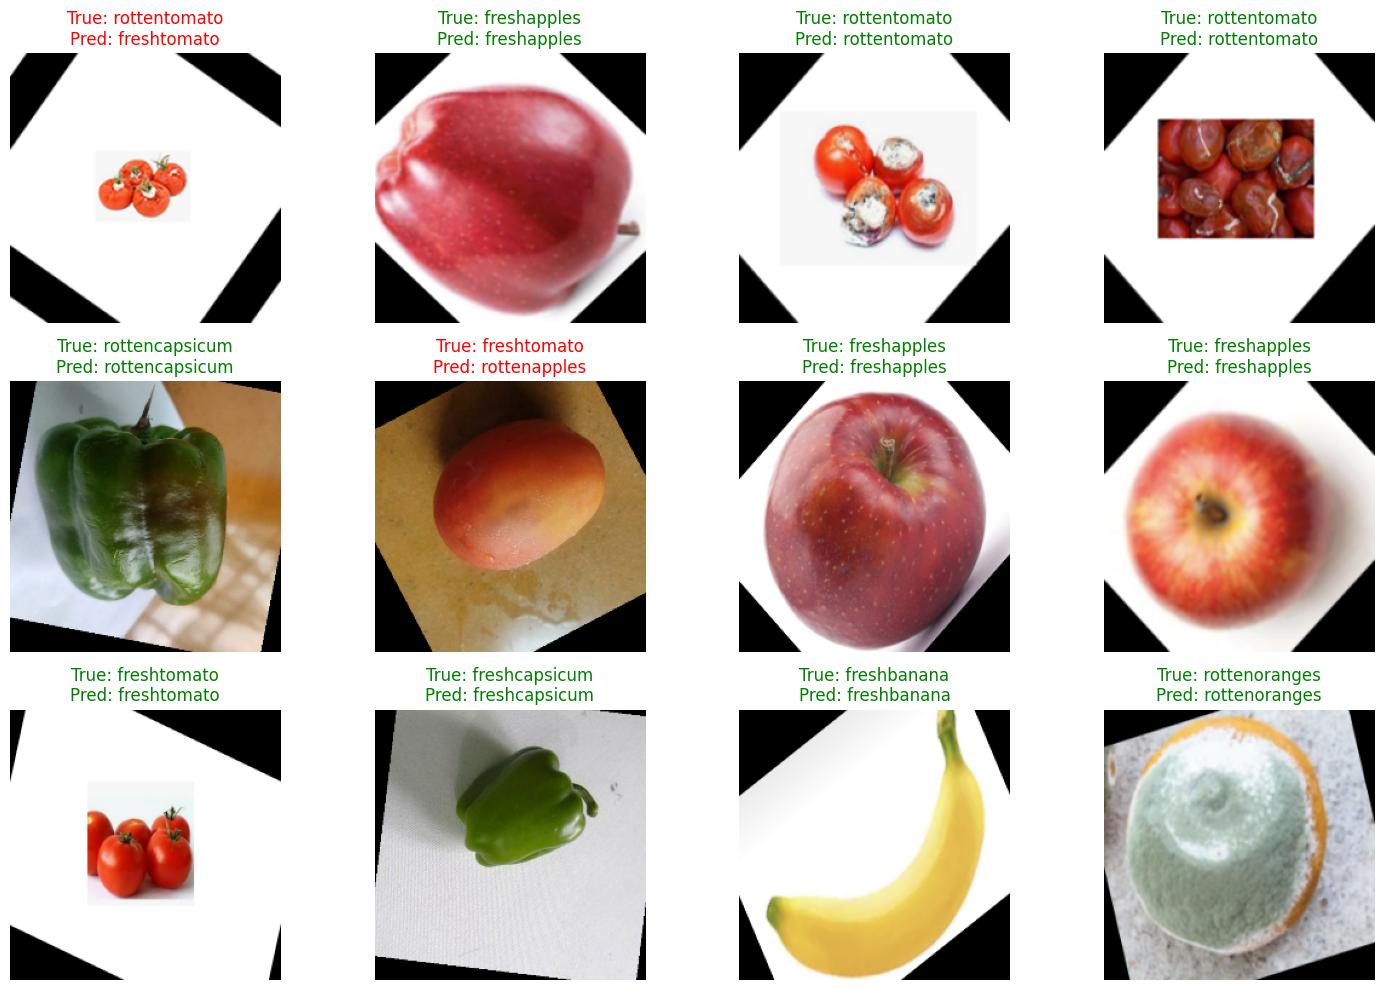

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get test images and labels
class_names = raw_test_ds.class_names
test_images = np.concatenate([x.numpy() for x, y in test_ds])
test_labels = np.concatenate([y.numpy() for x, y in test_ds])

# Predict labels
basic_model.load_weights('best_aug_model.keras')
y_pred_probs = basic_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Fix: Rescale normalized images to [0, 255] for display
def denormalize(image):
    image = image * 255.0
    return np.clip(image, 0, 255).astype("uint8")

# Plot sample predictions
def plot_sample_predictions(images, y_true, y_pred, class_names, num_samples=12):
    plt.figure(figsize=(15, 10))
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        ax = plt.subplot(3, 4, i + 1)
        image = denormalize(images[idx])
        plt.imshow(image)
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        color = "green" if y_true[idx] == y_pred[idx] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_sample_predictions(test_images, test_labels, y_pred, class_names)


In [11]:
from sklearn.metrics import classification_report
import numpy as np

# 1. Get ground truth and predictions
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = basic_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Classification report
print(classification_report(y_true, y_pred, target_names=raw_test_ds.class_names))

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step
                   precision    recall  f1-score   support

      freshapples       0.97      0.83      0.89       365
      freshbanana       0.95      0.92      0.94       371
 freshbittergroud       1.00      0.96      0.98        50
    freshcapsicum       0.97      1.00      0.98       149
    freshcucumber       0.73      0.15      0.24        75
        freshokra       0.72      0.41      0.52        96
     freshoranges       0.74      0.98      0.84       221
      freshpotato       0.50      0.83      0.62        81
      freshtomato       0.70      0.95      0.80       280
     rottenapples       0.70      0.85      0.77       488
     rottenbanana       0.99      0.71      0.83       441
rottenbittergroud       1.00      0.93      0.96        55
   rottencapsicum       1.00      0.96      0.98       136
   rottencucumber       0.27      0.17      0.21        64
       rottenokra       0.24      0.56      0.34        52
    rottenorang

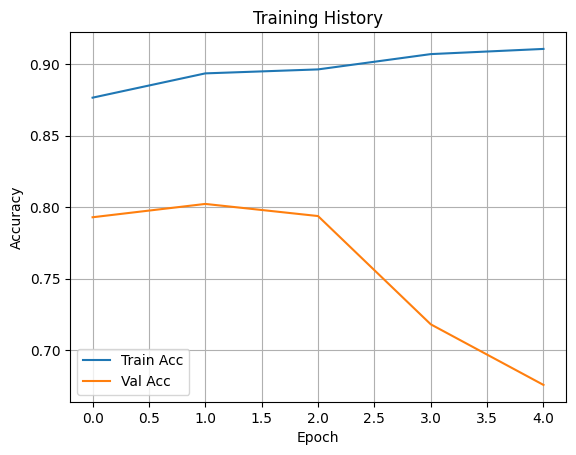

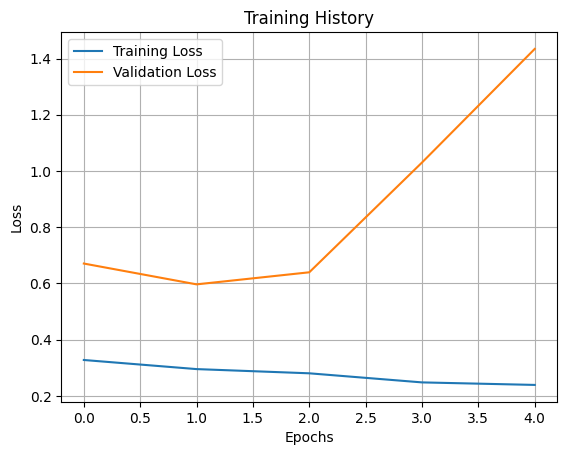

In [12]:
# import matplotlib.pyplot as plt

plt.plot(aug_model_history.history['accuracy'], label='Train Acc')
plt.plot(aug_model_history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training History')
plt.show()
    
plt.plot( aug_model_history.history["loss"], label = "Training Loss")
plt.plot( aug_model_history.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title('Training History')
plt.show()

2025-08-05 03:32:54.395607: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


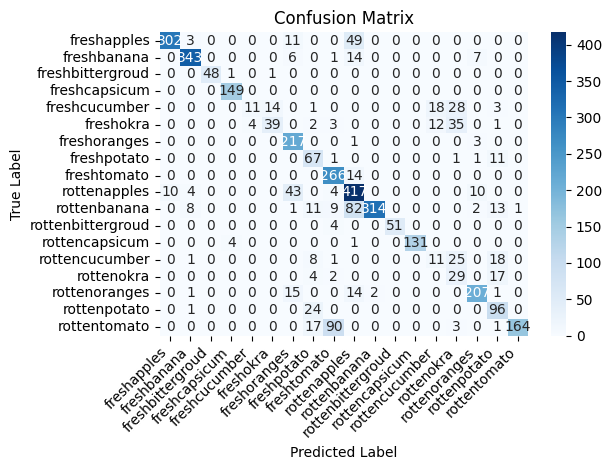

                   precision    recall  f1-score   support

      freshapples       0.97      0.83      0.89       365
      freshbanana       0.95      0.92      0.94       371
 freshbittergroud       1.00      0.96      0.98        50
    freshcapsicum       0.97      1.00      0.98       149
    freshcucumber       0.73      0.15      0.24        75
        freshokra       0.72      0.41      0.52        96
     freshoranges       0.74      0.98      0.84       221
      freshpotato       0.50      0.83      0.62        81
      freshtomato       0.70      0.95      0.80       280
     rottenapples       0.70      0.85      0.77       488
     rottenbanana       0.99      0.71      0.83       441
rottenbittergroud       1.00      0.93      0.96        55
   rottencapsicum       1.00      0.96      0.98       136
   rottencucumber       0.27      0.17      0.21        64
       rottenokra       0.24      0.56      0.34        52
    rottenoranges       0.90      0.86      0.88       

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get class names
class_names = raw_test_ds.class_names

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = basic_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
# plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


2025-08-05 03:34:02.515225: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


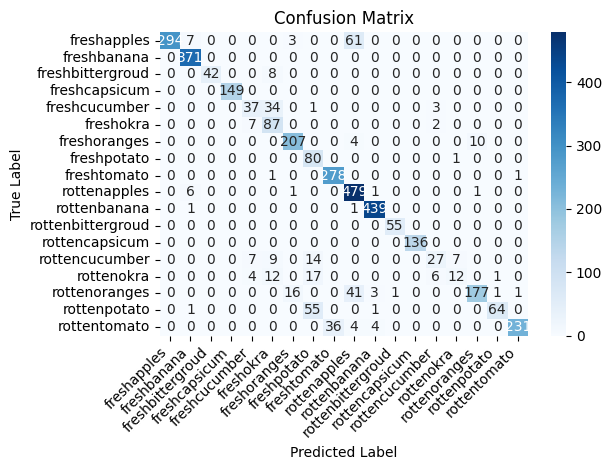

                   precision    recall  f1-score   support

      freshapples       1.00      0.81      0.89       365
      freshbanana       0.96      1.00      0.98       371
 freshbittergroud       1.00      0.84      0.91        50
    freshcapsicum       1.00      1.00      1.00       149
    freshcucumber       0.67      0.49      0.57        75
        freshokra       0.58      0.91      0.70        96
     freshoranges       0.91      0.94      0.92       221
      freshpotato       0.48      0.99      0.65        81
      freshtomato       0.89      0.99      0.94       280
     rottenapples       0.81      0.98      0.89       488
     rottenbanana       0.98      1.00      0.99       441
rottenbittergroud       0.98      1.00      0.99        55
   rottencapsicum       1.00      1.00      1.00       136
   rottencucumber       0.71      0.42      0.53        64
       rottenokra       0.60      0.23      0.33        52
    rottenoranges       0.94      0.74      0.83       

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get class names
class_names = raw_test_ds.class_names

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    basic_model.load_weights('/kaggle/input/best_basic_model/keras/default/1/best_basic_model.keras')
    preds = basic_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
# plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


## Phase 3: Fine Tune Pre-Trained Model

# MobileNetV2

In [3]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import mixed_precision

# === Mixed Precision (optional for MobileNetV2) ===
mixed_precision.set_global_policy('mixed_float16')

# === Config ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SEED = 42
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# === Paths ===
BASE_DIR = Path("/kaggle/working/split_dataset")
TRAIN_DIR = BASE_DIR / "Train"
VAL_DIR = BASE_DIR / "Val"
TEST_DIR = BASE_DIR / "Test"

# === Reproducibility ===
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})

# === Load datasets ===
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# === Class Names ===
class_names = raw_train_ds.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print("Class names:", class_names)

# === Normalize datasets ===
normalization_layer = layers.Rescaling(1.0 / 255)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(AUTOTUNE)
val_ds   = raw_val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(AUTOTUNE)
test_ds  = raw_test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)

# === Load and partially unfreeze MobileNetV2 ===
base_model = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
    pooling="avg"
)

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# === Build model ===
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax", dtype='float32')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# === Callbacks ===
checkpoint_cb = ModelCheckpoint(
    "best_mobilenetv2.keras",  # <-- Name updated
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Found 16524 files belonging to 18 classes.
Found 3535 files belonging to 18 classes.
Found 3560 files belonging to 18 classes.
Number of classes: 18
Class names: ['freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottenbittergroud', 'rottencapsicum', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │        23,058 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281,042 (8.70 MB)

 Trainable params: 1,549,138 (5.91 MB)

 Non-trainable params: 731,904 (2.79 MB)

Epoch 1/30
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8035 - loss: 0.6606
Epoch 1: val_accuracy improved from -inf to 0.97935, saving model to best_mobilenetv2.keras
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 120s 51ms/step - accuracy: 0.8036 - loss: 0.6605 - val_accuracy: 0.9793 - val_loss: 0.0625
Epoch 2/30
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9762 - loss: 0.0768
Epoch 2: val_accuracy improved from 0.97935 to 0.98614, saving model to best_mobilenetv2.keras
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 96s 46ms/step - accuracy: 0.9762 - loss: 0.0767 - val_accuracy: 0.9861 - val_loss: 0.0426
Epoch 3/30
2065/2066 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9905 - loss: 0.0330
Epoch 3: val_accuracy improved from 0.98614 to 0.98670, saving model to best_mobilenetv2.keras
2066/2066 ━━━━━━━━━━━━━━━━━━━━ 96s 46ms/step - accuracy: 0.9905 - loss: 0.0330 - val_accuracy: 0.9867 - val_loss: 0.0555
Epoch 4/30
2065/2066 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9919 - loss: 0.023

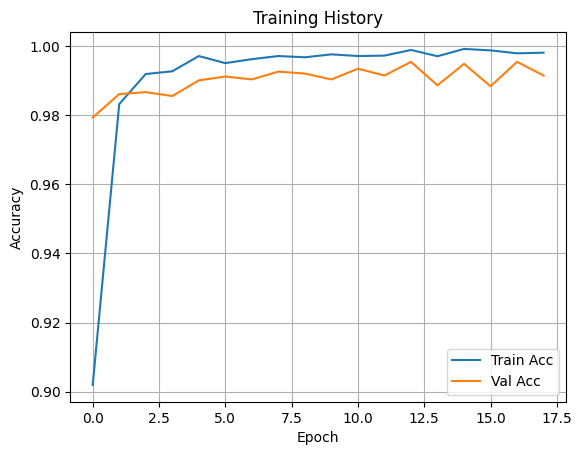

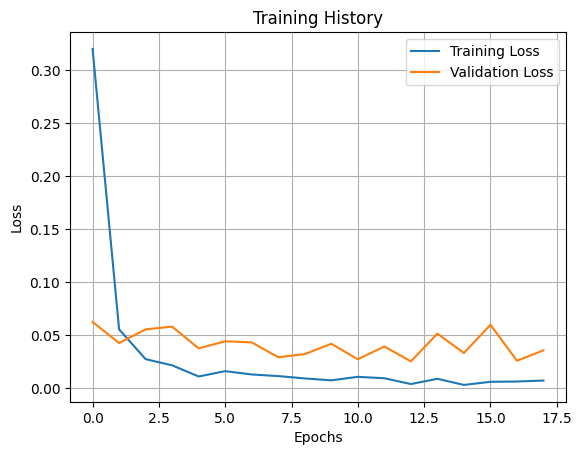

In [4]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training History')
plt.show()
    
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title('Training History')
plt.show()

In [5]:
model = tf.keras.models.load_model("best_mobilenetv2.keras")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


445/445 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9970 - loss: 0.0178
Test Accuracy: 0.9935 | Test Loss: 0.0354


445/445 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step


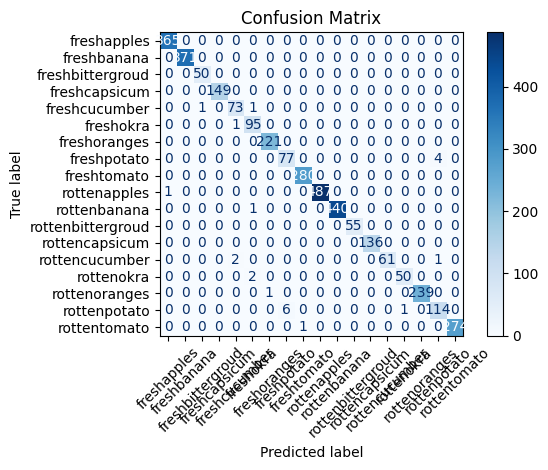

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels
y_true = np.concatenate([y for _, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [7]:
import pickle
with open("/kaggle/working/mobilenetv2_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)


In [8]:
import json
with open("/kaggle/working/class_names.json", "w") as f:
    json.dump(class_names, f)


In [9]:
with open("/kaggle/working/mobilenetv2_model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))


In [10]:
test_loss, test_acc = model.evaluate(test_ds)
with open("/kaggle/working/mobilenetv2_test_metrics.txt", "w") as f:
    f.write(f"Test Accuracy: {test_acc:.4f}\nTest Loss: {test_loss:.4f}")


445/445 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9970 - loss: 0.0178


In [11]:
np.save("/kaggle/working/confusion_matrix.npy", cm)


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("/kaggle/working/mobilenetv2_model.tflite", "wb") as f:
    f.write(tflite_model)


In [ ]:
import tf2onnx
import tensorflow as tf

model = tf.keras.models.load_model("/kaggle/working/best_mobilenetv2.keras")
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec)
with open("/kaggle/working/mobilenetv2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


2025-08-04 18:00:33.391907: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


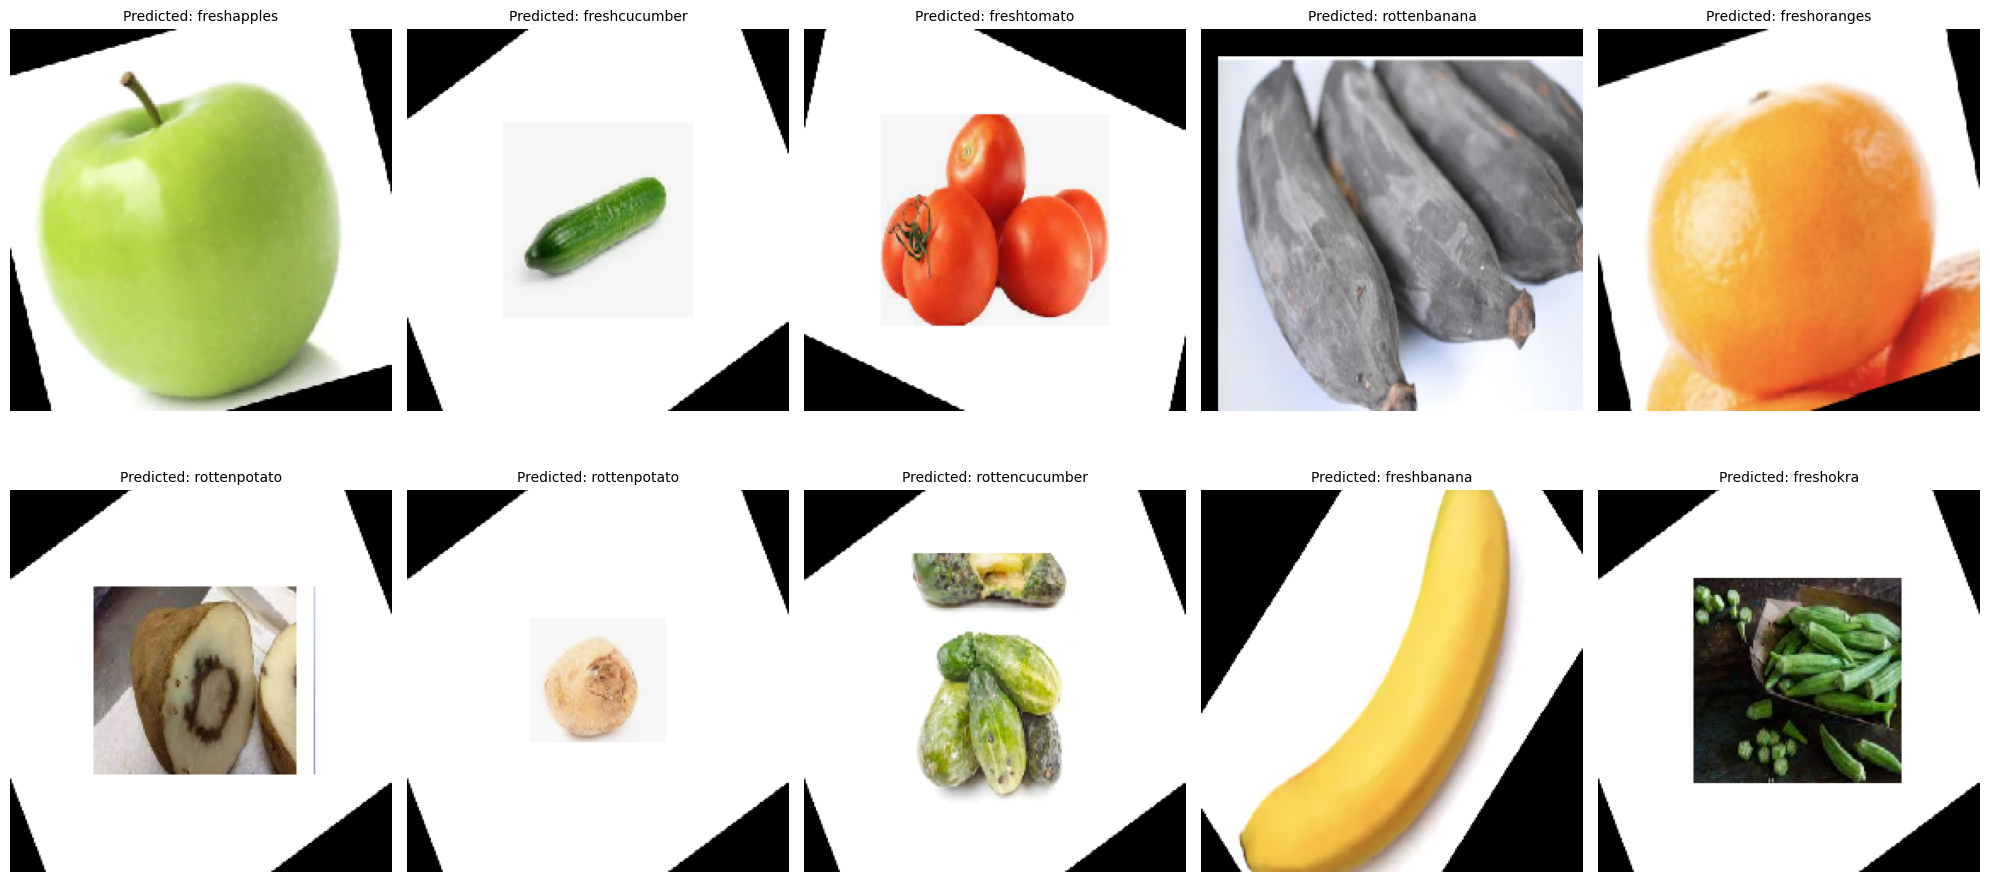

In [18]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the test folder
test_root = "/kaggle/input/fresh-and-stale-classification/dataset/Test"

# Load the saved model (adjust filename as needed)
model = load_model("best_mobilenetv2.keras")

# Get class names from the training data or saved label index
# Replace this with your actual class names list (in order of model training)
class_names = [
    'freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber',
    'freshokra', 'freshoranges', 'freshpotato', 'freshtomato',
    'rottenapples', 'rottenbanana', 'rottenbittergroud', 'rottencapsicum',
    'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato'
]

# Collect all image paths recursively (ignore subfolder names)
image_paths = []
for root, _, files in os.walk(test_root):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(root, file))

# Pick 10 random images
sample_paths = random.sample(image_paths, 10)

# Plot setup
plt.figure(figsize=(20, 10))

for i, img_path in enumerate(sample_paths):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_batch = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_batch, verbose=0)
    pred_class = class_names[np.argmax(preds)]

    # Show image and prediction
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [15]:
import os
import shutil
import random
from pathlib import Path

# Source: original test directory
src_dir = "/kaggle/input/fresh-and-stale-classification/dataset/Test"
# Destination: new directory for 100 random samples
dest_dir = "/kaggle/working/random_100_images"

# Create destination directory
os.makedirs(dest_dir, exist_ok=True)

# Collect all image file paths (recursive through subfolders)
all_images = []
for root, _, files in os.walk(src_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp")):
            all_images.append(os.path.join(root, file))

# Shuffle and pick 100 unique images
random.shuffle(all_images)
sampled_images = all_images[:100]

# Copy to destination
for i, img_path in enumerate(sampled_images):
    ext = Path(img_path).suffix
    dest_path = os.path.join(dest_dir, f"unseen_{i+1:03}{ext}")
    shutil.copy(img_path, dest_path)

print(f"✅ Saved 100 unseen random images to: {dest_dir}")


✅ Saved 100 unseen random images to: /kaggle/working/random_100_images


In [20]:
import shutil

# Source directory of the images
src_dir = "/kaggle/working/random_100_images"
# Destination ZIP file path
zip_path = "/kaggle/working/unseen_images_100.zip"

# Create the ZIP file
shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=src_dir)

print(f"✅ ZIP file created at: {zip_path}")


✅ ZIP file created at: /kaggle/working/unseen_images_100.zip
